# Batch correction using Python (scanpy) tools

This Jupyter notebook is a template notebook for batch correction of 10X data using [BBKNN](https://github.com/Teichlab/bbknn) and [scanorama](http://cb.csail.mit.edu/cb/scanorama) tools.

In [39]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata

import bbknn
import scanorama

import os
import scipy
from scipy import sparse
import sys

sc.settings.verbosity = 3 
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

scanpy==1.4 anndata==0.6.18 numpy==1.16.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Load datasets

In this notebook will use 3 publicly available 10X datasets:
- [1k PBMCs from a Healthy Donor (v2 chemistry)](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v2)
- [1k PBMCs from a Healthy Donor (v3 chemistry)](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v3)
- [3k PBMCs from a Healthy Donor (v1 chemistry)](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

In [40]:
# load datasets as h5
A_data = sc.read_10x_h5("../data/pbmc_1k_v2_filtered_feature_bc_matrix.h5")
B_data = sc.read_10x_h5("../data/pbmc_1k_v3_filtered_feature_bc_matrix.h5")
# no h5 file available for this dataset, therefore using read_10x_mtx
C_data = sc.read_10x_mtx("../data/pbmc3k_filtered_gene_bc_matrices/hg19/", cache=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ../data/pbmc_1k_v2_filtered_feature_bc_matrix.h5 (0:00:00.15)
reading ../data/pbmc_1k_v3_filtered_feature_bc_matrix.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:00.18)
... reading from cache file ./cache/data-pbmc3k_filtered_gene_bc_matrices-hg19-matrix.h5ad


## QC of the data

### Filtering
Here we follow a standard scanpy workflow:
- Remove cells with less than 200 genes expressed
- Remove genes expressed in less than 3 cells
- Calculate the percentage of mitochondrial genes
- Create n_counts per cell

In [41]:
datasets =[A_data, B_data, C_data]
for dataset in datasets:
    dataset.var_names_make_unique()
    #filter cells and genes
    sc.pp.filter_cells(dataset, min_genes=200)
    sc.pp.filter_genes(dataset, min_cells=3) 
    mito_genes = [name for name in dataset.var_names if name.startswith('MT-')]
    dataset.obs['percent_mito'] = np.sum(dataset[:, mito_genes].X, axis=1).A1 / np.sum(dataset.X, axis=1).A1
    dataset.obs['n_counts'] = dataset.X.sum(axis=1).A1

filtered out 1 cells that have less than 200 genes expressed
filtered out 20468 genes that are detected in less than 3 cells
filtered out 46 cells that have less than 200 genes expressed
filtered out 18292 genes that are detected in less than 3 cells
filtered out 19024 genes that are detected in less than 3 cells


### QC plots

... storing 'feature_types' as categorical
... storing 'genome' as categorical


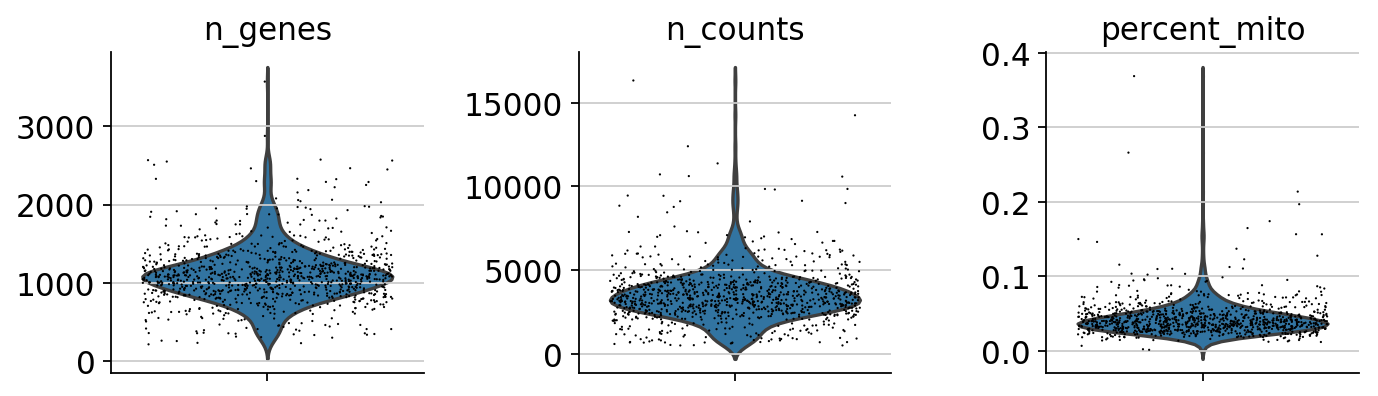

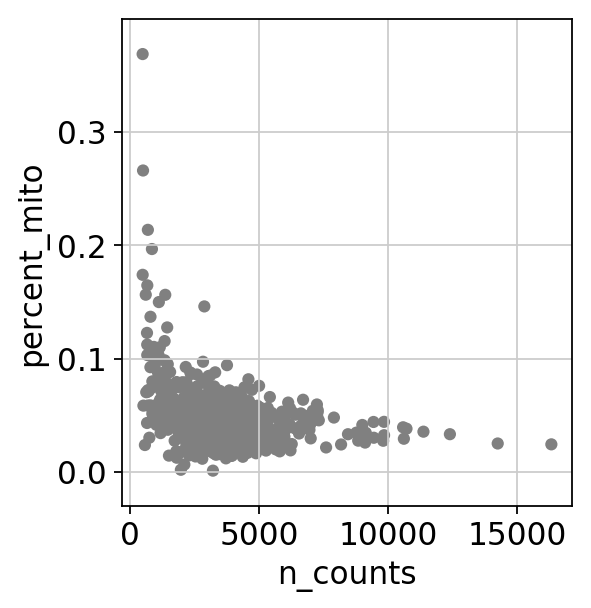

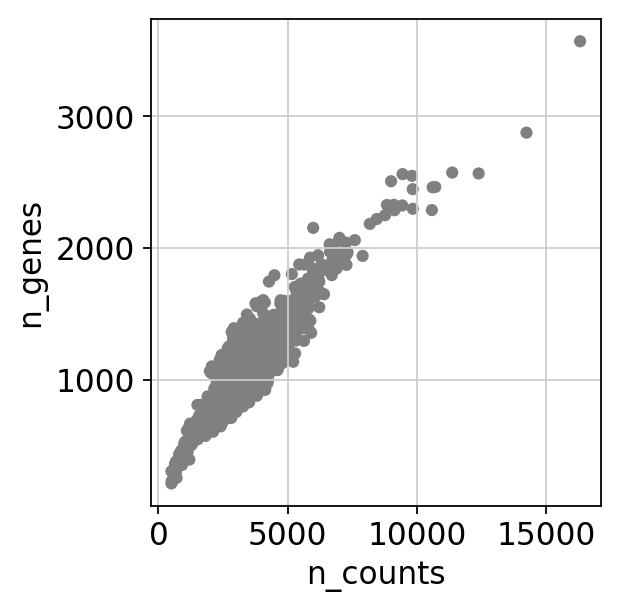

... storing 'feature_types' as categorical
... storing 'genome' as categorical


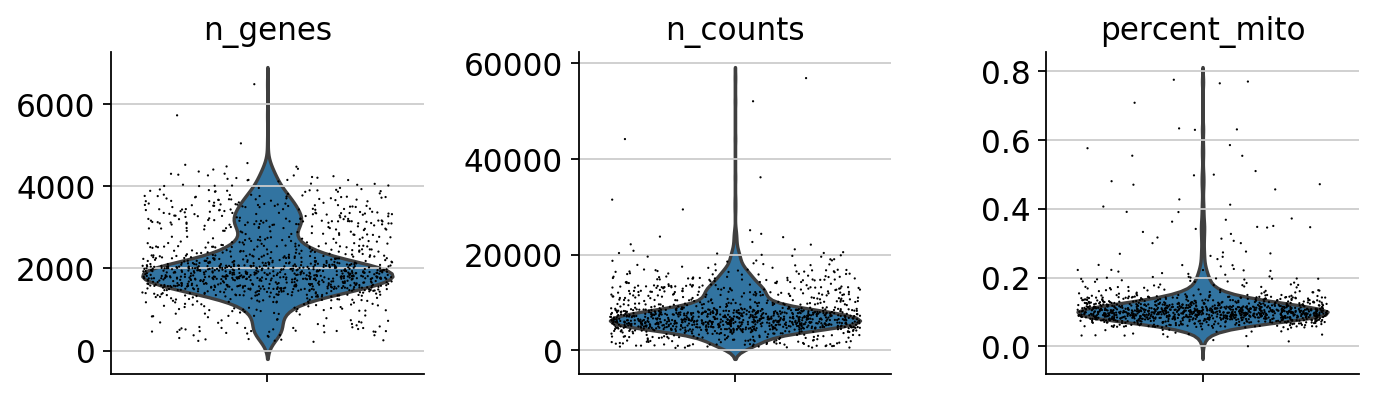

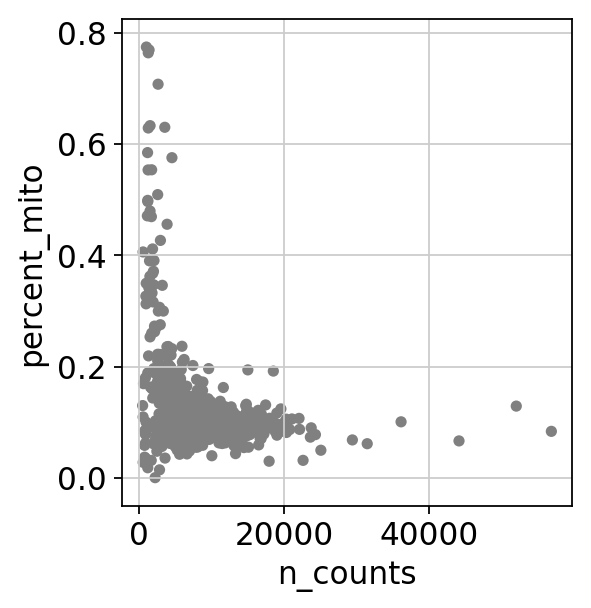

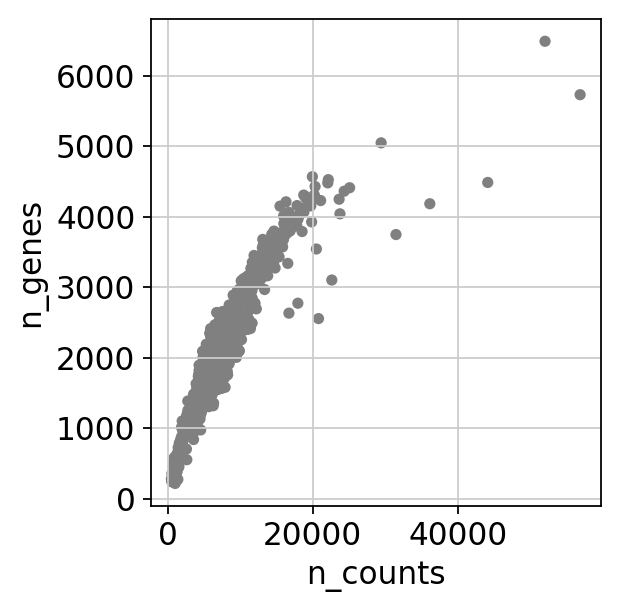

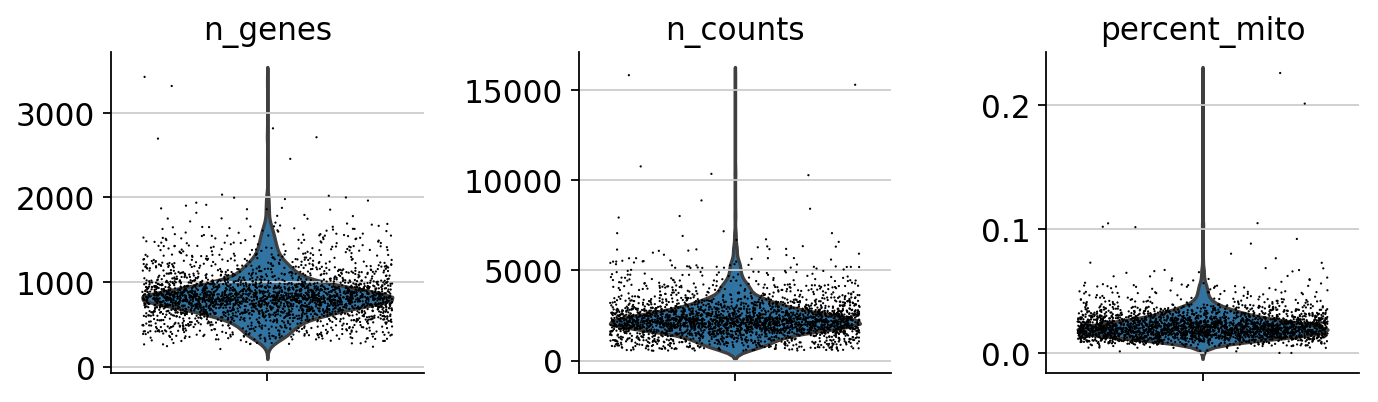

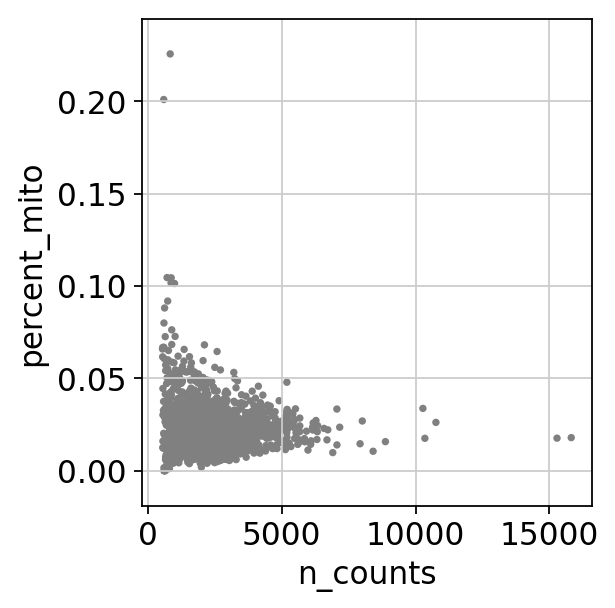

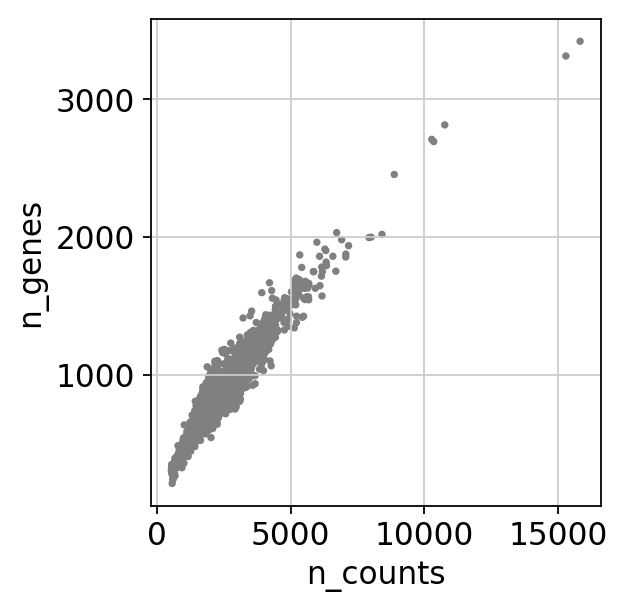

In [42]:
for dataset in datasets:
    sc.pl.violin(dataset, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True)
    sc.pl.scatter(dataset, x='n_counts', y='percent_mito')
    sc.pl.scatter(dataset, x='n_counts', y='n_genes')

### Filtering based on mitochondrial content
We would like to filter the cells that have less than a 10% expression of mitochondrial genes 

In [43]:
for dataset in datasets:
    dataset= dataset[dataset.obs['percent_mito'] < 0.1, :]

### Normalization and log-transforming 

In [44]:
for dataset in datasets:
    sc.pp.normalize_per_cell(dataset, counts_per_cell_after= 10e4, key_n_counts= 'n_counts')
    sc.pp.log1p(dataset)

### (Optional) Identify highly variable genes 
Before doing batch correction the datasets have to be merged. When merging the datasets either common genes or highly variable genes can be used. In this notebook we use common genes, but also provide code co calculate highly variable genes.

In [45]:
# for dataset in datasets: 
#     filter_result = sc.pp.filter_genes_dispersion(dataset.X, min_mean=0.0125, max_mean=0.02, min_disp=0.7)
#     sc.pl.filter_genes_dispersion(filter_result)
#     print(sum([i[0] for i in filter_result]),"HVGs out of:", len(filter_result), "genes")
#     dataset = dataset[:, filter_result.gene_subset]

### Merge data

In [46]:
merged = A_data.concatenate(B_data, C_data, join="inner", batch_key = 'batch')

Use intersection (`inner`) or union (`outer`) of variables. `batch_key` denotes the column name corresponding to the batch identity of each cell. Default is `batch` but you may name it as desired.

### Visualization

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:01.31) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP


... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical
... storing 'feature_types-1' as categorical
... storing 'genome-1' as categorical


    finished (0:00:13.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)


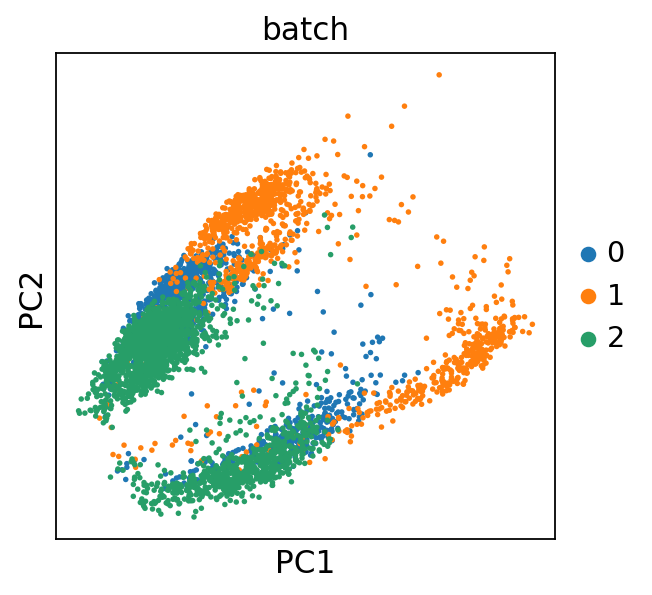

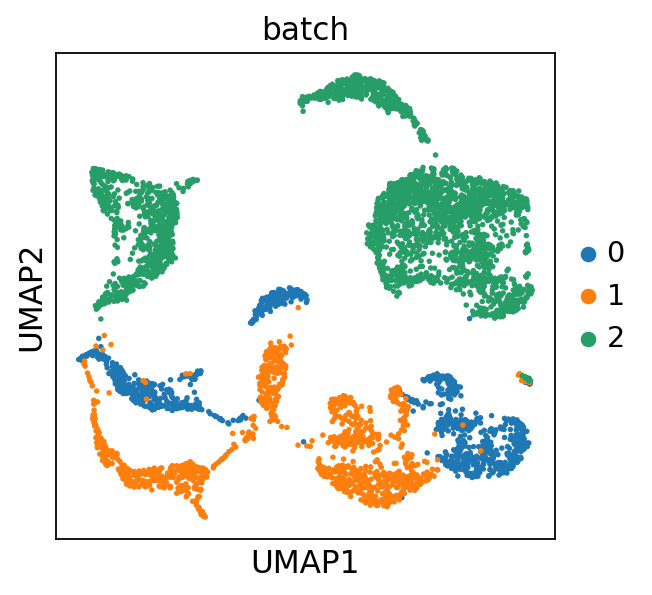

In [47]:
sc.tl.pca(merged)
sc.pp.neighbors(merged,n_pcs=10, n_neighbors=20)
sc.tl.umap(merged)
sc.pl.pca(merged, color=['batch'])
sc.pl.umap(merged, color=['batch'])

## BBKNN
Let's run BBKNN batch correction.

In [48]:
merged_bbknn = bbknn.bbknn(merged, neighbors_within_batch=5, n_pcs=10, save_knn=True, copy=True)

computing batch balanced neighbors
    finished (0:00:00.64) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


Visualise correction:

computing UMAP
    finished (0:00:10.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)


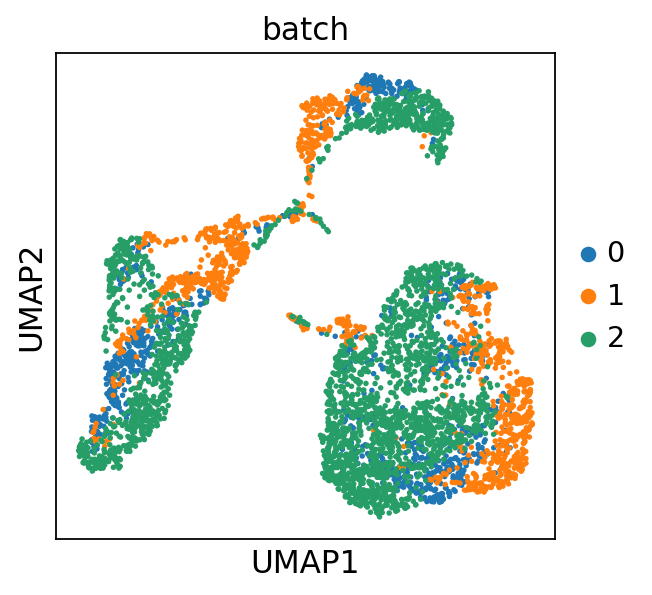

In [50]:
sc.tl.umap(merged_bbknn)
sc.pl.umap(merged_bbknn, color=['batch'])

## Scanorama
Scanorama requires loading the individual objects as a list. It outputs corrected expression cell x gene matrices.

In [53]:
A_data = merged[merged.obs['batch'] == '0']
B_data = merged[merged.obs['batch'] == '1']
C_data = merged[merged.obs['batch'] == '2']
datasets = [A_data,B_data,C_data]

In [54]:
corrected = scanorama.correct_scanpy(datasets)

Found 10894 genes among all datasets
[[0.         0.81037415 0.47638191]
 [0.         0.         0.32227891]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)


Now we need to merge Scanorama corrected data into one object:

In [57]:
merged = corrected[0].concatenate(corrected[1:], join="inner", batch_key = 'batch')

Let's visualise the Scanorama results:

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:01.62) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP


... storing 'feature_types-0-0' as categorical
... storing 'genome-0-0' as categorical
... storing 'feature_types-1-0' as categorical
... storing 'genome-1-0' as categorical


    finished (0:00:12.36) --> added
    'X_umap', UMAP coordinates (adata.obsm)


... storing 'feature_types-0-1' as categorical
... storing 'genome-0-1' as categorical
... storing 'feature_types-1-1' as categorical
... storing 'genome-1-1' as categorical
... storing 'feature_types-0-2' as categorical
... storing 'genome-0-2' as categorical
... storing 'feature_types-1-2' as categorical
... storing 'genome-1-2' as categorical


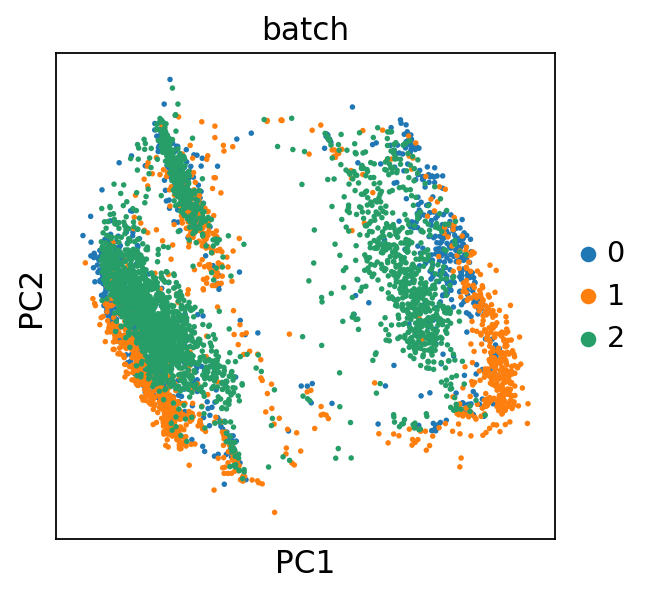

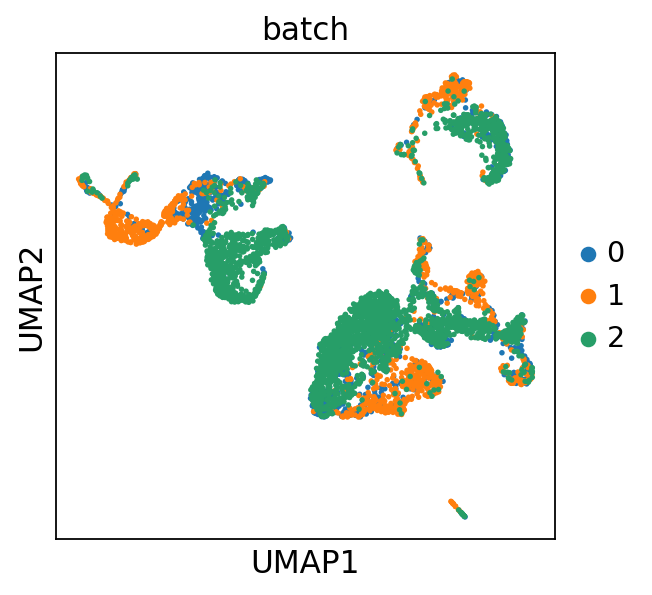

In [58]:
sc.tl.pca(merged)
sc.pp.neighbors(merged,n_pcs=10, n_neighbors=20)
sc.tl.umap(merged)

sc.pl.pca(merged, color=['batch'])
sc.pl.umap(merged, color=['batch'])